In [462]:
"""
importing examples 
├── project (package)
│   ├── src (package)
│   │   ├── __init__.py
│   │   └── utils.py
│   |── clustering.ipynb
    └── __init__.py

import src ---> src.utils.test(10)
from src import utils ---> utils.test(10)
from src.utils import test ---> test(10) 
----------------------------------------
please import each library in its own line 
e.g.

((THIS IS TRUE))
import os
import sys

((THIS IS WRONG))
import os,sys

----------------------------------------
in the package case its ok to import all things in one liune
e.g. 
from src import utils,constants   ((Thats OK !!))
----------------------------------------
import proiority : (very important)
1) Standard library imprts  e.g. sys,os
2) Third party imports e.g. pandas , numpy
3) Local imports e.g. utils , constants and other things inside the project
"""


'\nimporting examples \n├── project (package)\n│   ├── src (package)\n│   │   ├── __init__.py\n│   │   └── utils.py\n│   |── clustering.ipynb\n    └── __init__.py\n\nimport src ---> src.utils.test(10)\nfrom src import utils ---> utils.test(10)\nfrom src.utils import test ---> test(10) \n----------------------------------------\nplease import each library in its own line \ne.g.\n\n((THIS IS TRUE))\nimport os\nimport sys\n\n((THIS IS WRONG))\nimport os,sys\n\n----------------------------------------\nin the package case its ok to import all things in one liune\ne.g. \nfrom src import utils,constants   ((Thats OK !!))\n----------------------------------------\nimport proiority : (very important)\n1) Standard library imprts  e.g. sys,os\n2) Third party imports e.g. pandas , numpy\n3) Local imports e.g. utils , constants and other things inside the project\n'

In [463]:
# Standard libraries Imports
import json
# Third party Imports
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA 
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
# Local imports
from src.constants import DATA_API
from src.utils import one_hot_encoding

Read the data using the API provided by the website

In [464]:
# response = requests.get(DATA_API) # get the data from the API
# json_response = json.loads(response.content) # convert the response from binary format to json (dict)
# data =pd.DataFrame(json_response) # create the dataframe

In [465]:
data = pd.read_csv("data/Citywide_Mobility_Survey_-_Person_Survey_2019.csv")

In [466]:
data.head()

,hh_id,weight,cms_zone,survey_mode,person_id,person_num,is_participant,num_days,num_days_complete,num_trips,...,race_native_hawaiian,race_white,race_other,disability_hearing,disability_seeing,disability_walking,disability_mobility,disability_dressing,disability_concentrating,disability_none
0,191546322,0.00000,Inner Brooklyn,1,19154632203,3,0,NaN,NaN,NaN,...,995,995,995,995,995,995,995,995,995,995
1,191546322,0.00000,Inner Brooklyn,1,19154632202,2,0,NaN,NaN,NaN,...,995,995,995,995,995,995,995,995,995,995
2,191546322,212.12729,Inner Brooklyn,1,19154632201,1,1,7.0,7.0,23.0,...,1,0,0,0,0,0,0,0,0,1
3,19241657,0.00000,Middle Queens,1,1924165703,3,0,NaN,NaN,NaN,...,995,995,995,995,995,995,995,995,995,995
4,19241657,0.00000,Middle Queens,1,1924165702,2,0,NaN,NaN,NaN,...,995,995,995,995,995,995,995,995,995,995


# Missing Values

convert the -9998 value to NaN to handle it also with missing values

In [467]:
for column in data.columns:
    data[column] = data[column].replace(-9998,np.nan)
    data[column] = data[column].replace("-9998",np.nan)

compute the percentage of null values of each column

In [468]:
null_percentage = data.isna().sum().apply(lambda x:x/data.shape[0]*100).sort_values(ascending=False)[data.isna().sum()>0] 

<AxesSubplot: >

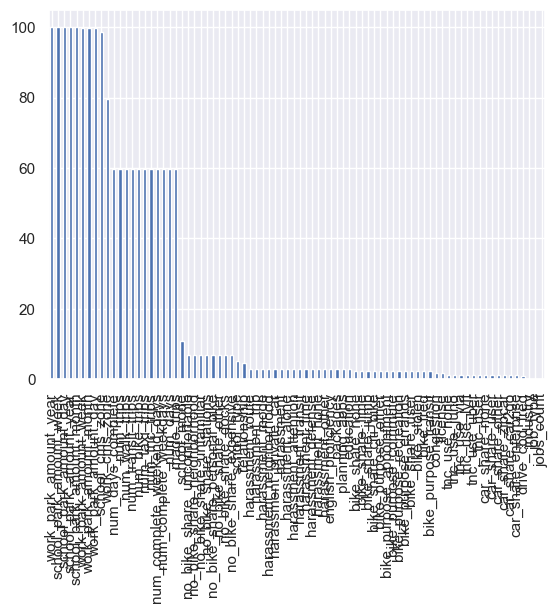

In [469]:
null_percentage.plot(kind='bar')

remove any column have more than 50% NULL

In [470]:
print(f"before Remove  {data.shape}")
data.drop(columns=null_percentage[null_percentage>50].index.to_list(),inplace=True)
print(f"after Remove  {data.shape}")


before Remove  (8286, 165)
after Remove  (8286, 144)


for the rest we will remove any row have null value

In [471]:
print(f"before Remove  {data.shape}")
data = data.dropna(axis=0)
print(f"after Remove  {data.shape}")

before Remove  (8286, 144)
after Remove  (6504, 144)


remove any row have is_participant value not 1 becouse all the rest of the values are null

In [472]:
print(f"before Remove  {data.shape}")
data = data[data["is_participant"]==1]
print(f"after Remove  {data.shape}")

before Remove  (6504, 144)
after Remove  (2692, 144)


In [473]:
data.drop(["hh_id","person_id","relationship","is_participant"],axis=1,inplace=True)

# Encoding Features

In [474]:
with open("data/columns_encoding.json") as file:
    columns_dictionary = json.loads(file.read()) # read the file as string and convert it to dictionary

In [475]:
columns_dictionary

{'survey_mode': {'1': 'rMove',
  '2': 'rSurvey',
  '3': 'Call center',
  '995': 'skip logic'},
 'is_participant': {'0': 'Not selected', '1': 'Selected', '995': 'skip logic'},
 'made_trips': {'0': 'Not selected', '1': 'Selected', '995': 'skip logic'},
 'relationship': {'0': 'Self',
  '1': 'Spouse or partner',
  '2': 'Son or daughter',
  '3': 'Father or mother',
  '4': 'Brother or sister',
  '5': 'Other relative',
  '6': 'Roommate or friend',
  '7': 'Household help',
  '995': 'skip logic'},
 'age': {'1': 'Under 5',
  '2': '5-15',
  '3': '16-17',
  '4': '18-24',
  '5': '25-34',
  '6': '35-44',
  '7': '45-54',
  '8': '55-64',
  '9': '65-74',
  '10': '75-84',
  '11': '85 or older',
  '995': 'skip logic'},
 'employment': {'1': 'Employed full-time',
  '2': 'Employed part-time',
  '3': 'Primarily self-employed',
  '6': 'Not currently employed',
  '7': 'Unpaid volunteer or intern',
  '995': 'skip logic'},
 'worker': {'0': 'Not employed', '1': 'Employed', '995': 'skip logic'},
 'student': {'0': 

for each column_name in the dictionary encode the data using the dictionary values to create one_hot_encoding

In [476]:
for column_name in columns_dictionary:
    data = one_hot_encoding(data=data,column=column_name,dictionary=columns_dictionary[column_name])

In [477]:
data.dtypes.unique()

array([dtype('float64'), dtype('O'), dtype('int64'), dtype('uint8')],
      dtype=object)

In [478]:
data.select_dtypes(include='object').columns # will handle it later

Index(['cms_zone', 'first_travel_date', 'last_travel_date'], dtype='object')

select numberic features only to apply kmeans on them

In [479]:
numeric_fetures = data.select_dtypes(include=np.number).columns.tolist()
data_numeric = data[numeric_fetures]
data_numeric.shape

(2692, 286)

apply Standard Scaler on the Data

In [480]:
data_numeric_standarized = StandardScaler().fit_transform(data_numeric)
data_numeric_standarized = pd.DataFrame(data_numeric_standarized, columns = data_numeric.columns)
data_numeric_standarized.head()
# data_numeric_standarized = data_numeric

,weight,person_num,smartphone_type,jobs_count,bike_num_days,survey_mode_Call center,survey_mode_rMove,survey_mode_rSurvey,age_18-24,age_25-34,...,disability_walking_Not selected,disability_walking_Selected,disability_mobility_Not selected,disability_mobility_Selected,disability_dressing_Not selected,disability_dressing_Selected,disability_concentrating_Not selected,disability_concentrating_Selected,disability_none_Not selected,disability_none_Selected
0,-0.270686,0.0,-0.507334,1.449614,-1.182246,-0.252213,0.679305,-0.586502,-0.274007,1.998608,...,0.402302,-0.284824,0.297584,-0.131851,0.284824,-0.104355,0.314999,-0.163393,-0.36141,0.468191
1,-0.107977,0.0,0.873600,-0.690243,-1.186326,-0.252213,0.679305,-0.586502,-0.274007,1.998608,...,0.402302,-0.284824,0.297584,-0.131851,0.284824,-0.104355,0.314999,-0.163393,-0.36141,0.468191
2,-0.289147,0.0,0.873600,-0.690243,-1.186326,-0.252213,0.679305,-0.586502,-0.274007,-0.500348,...,0.402302,-0.284824,0.297584,-0.131851,0.284824,-0.104355,0.314999,-0.163393,-0.36141,0.468191
3,-0.286614,0.0,0.873600,-0.690243,-1.176126,-0.252213,0.679305,-0.586502,-0.274007,1.998608,...,0.402302,-0.284824,0.297584,-0.131851,0.284824,-0.104355,0.314999,-0.163393,-0.36141,0.468191
4,-0.270973,0.0,-0.507334,-0.688090,0.843432,-0.252213,0.679305,-0.586502,-0.274007,1.998608,...,0.402302,-0.284824,0.297584,-0.131851,0.284824,-0.104355,0.314999,-0.163393,-0.36141,0.468191


# Hyper Parameter Tuning

finding the optimal k using elbow

In [481]:
result = []
potential_k = list(range(2, 21))
for k in potential_k:
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(data_numeric_standarized)
  result.append(kmeans.inertia_)
  


In [482]:
result[1:5]

[692805.3407871228, 675409.4237522691, 665861.5697165453, 653981.5872582085]

In [483]:
optimal_k_elbow = result[1:5].index(min(result[1:5]))+1


finding the optimal k using silhouette_score

In [484]:
sil = []
kmax = 20
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(data_numeric_standarized)
  labels = kmeans.labels_
  sil.append(silhouette_score(data_numeric_standarized, labels, metric = 'euclidean'))

In [485]:
result = [value/10000 for value in result]


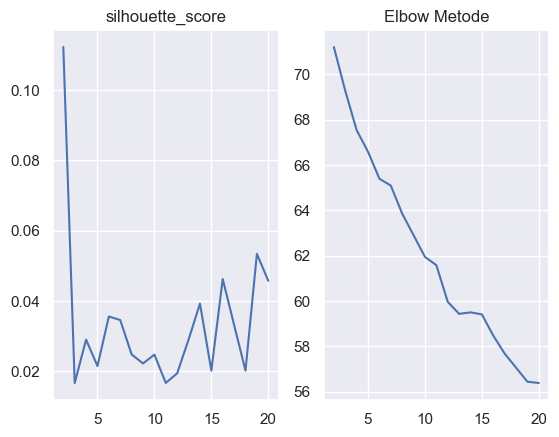

In [486]:


fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(range(2,kmax+1),sil)
ax2.plot(potential_k, result)
ax1.set_title('silhouette_score')
ax2.set_title('Elbow Metode')
plt.show()


In [487]:
optimal_k = sil.index(max(sil))+2

In [488]:
print(f"optimal K using elbow : {optimal_k_elbow}")
print(f"optimal K using silh : {optimal_k}")

optimal K using elbow : 4
optimal K using silh : 2


# Modeling

train the model with the optimal_k value 

In [520]:
kmeans = KMeans(n_clusters=optimal_k)
y_kmeans = kmeans.fit_predict(data_numeric_standarized)
centers = kmeans.cluster_centers_

# Evaluating

use PCA to reduce the dimentions of the data to plot it in 2d space

In [521]:
pca_model = PCA(n_components = 2)
pca_model.fit(data_numeric_standarized)

PCA(n_components=2)

In [522]:
training_data_pca = pca_model.transform(data_numeric_standarized)
centers_pca = pca_model.transform(centers)

c:\Users\nasser\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


draw the data in 2d space

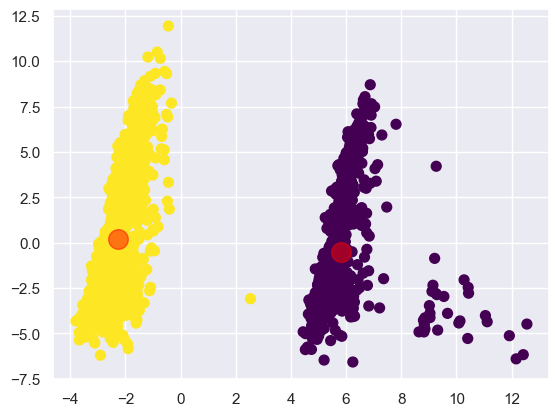

In [523]:
plt.scatter(training_data_pca[:, 0],
            training_data_pca[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=200, alpha=0.5)

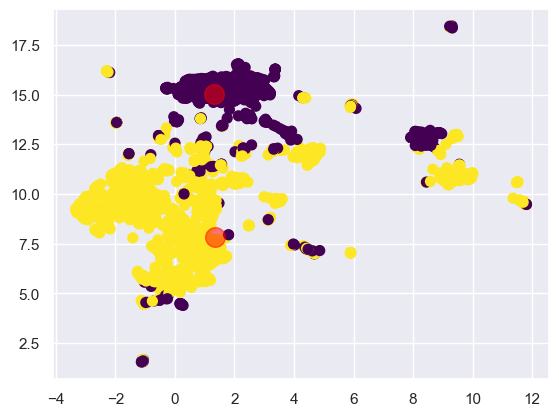

In [524]:
import umap
reducer = umap.UMAP(n_components=2)
umap_model = reducer.fit(data_numeric_standarized)
training_data_embedding = umap_model.transform(data_numeric_standarized)
centers_embedding = umap_model.transform(centers)

# plot the data in the low dim with the cluster results
plt.scatter(training_data_embedding[:, 0],
            training_data_embedding[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers_embedding[:, 0], centers_embedding[:, 1], c='red', s=200, alpha=0.5);

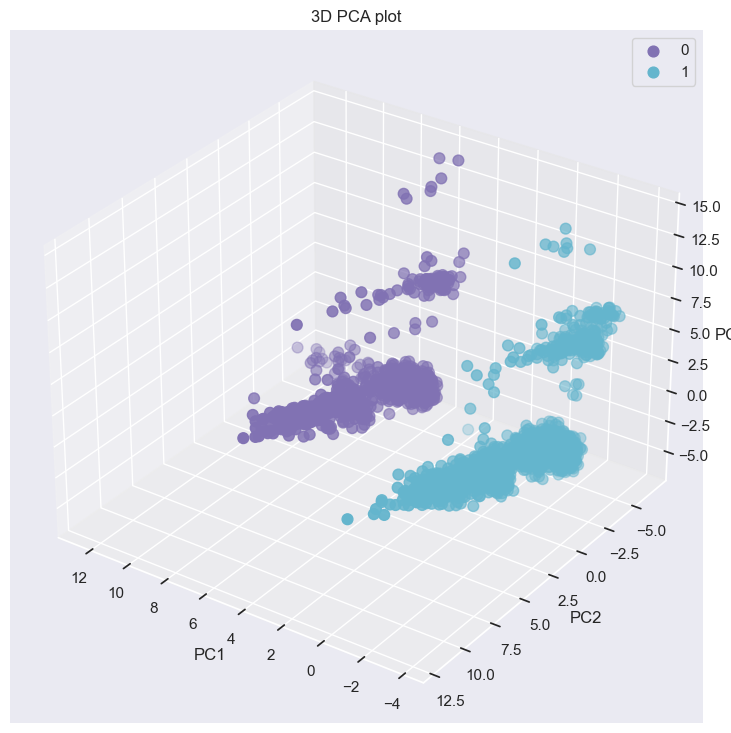

In [525]:
pca = PCA(n_components=3)
pca.fit(data_numeric_standarized)
pca_bcancer = pca.transform(data_numeric_standarized)
cdict = {0:'m',1:'c',2:'r',3:'y'}
label = {0:'0',1:'1',2:"2",3:"3"}
y = y_kmeans

Xax = pca_bcancer[:,0]
Yax = pca_bcancer[:,1]
Zax = pca_bcancer[:,2]

fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(111, 
                     projection='3d')
 
for l in np.unique(y):
 ix=np.where(y==l)
 ax.scatter(Xax[ix], 
            Yax[ix], 
            Zax[ix], 
            c=cdict[l], 
            s=60,
           label=label[l])
 
ax.set_xlabel("PC1", 
              fontsize=12)
ax.set_ylabel("PC2", 
              fontsize=12)
ax.set_zlabel("PC3", 
              fontsize=12)
 
ax.view_init(30, 125)
ax.legend()
plt.title("3D PCA plot")
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.11224444068394356
For n_clusters = 3 The average silhouette_score is : 0.02224768675771457
For n_clusters = 4 The average silhouette_score is : 0.02894350939522572
For n_clusters = 5 The average silhouette_score is : 0.027851468385545704
For n_clusters = 6 The average silhouette_score is : 0.021925371392559567
For n_clusters = 7 The average silhouette_score is : 0.039079074314931586
For n_clusters = 8 The average silhouette_score is : 0.028116523065653043
For n_clusters = 9 The average silhouette_score is : 0.027194949585715156


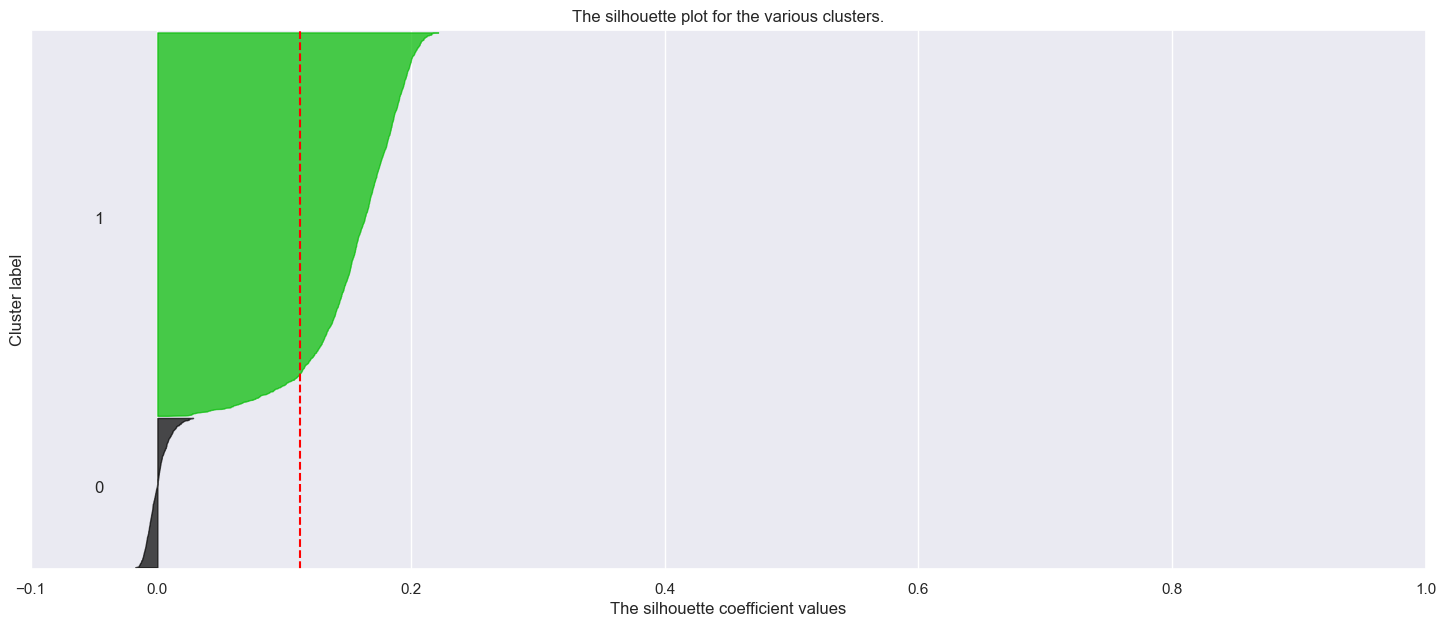

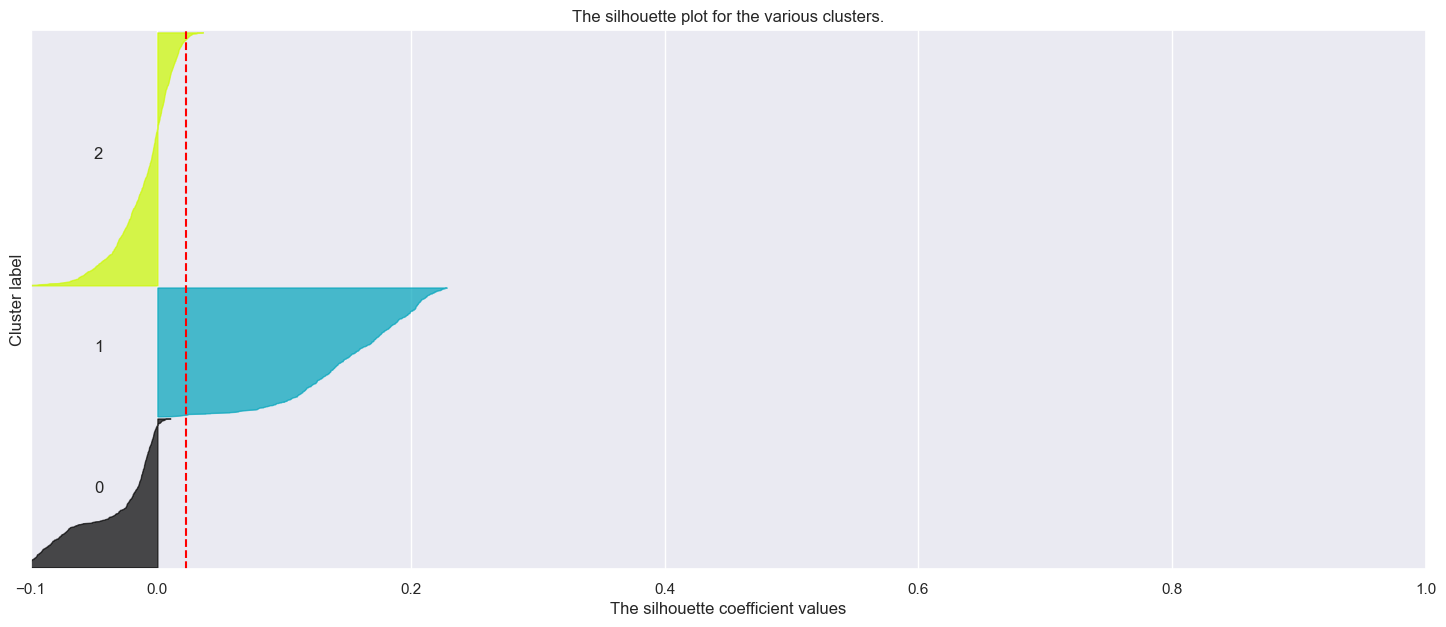

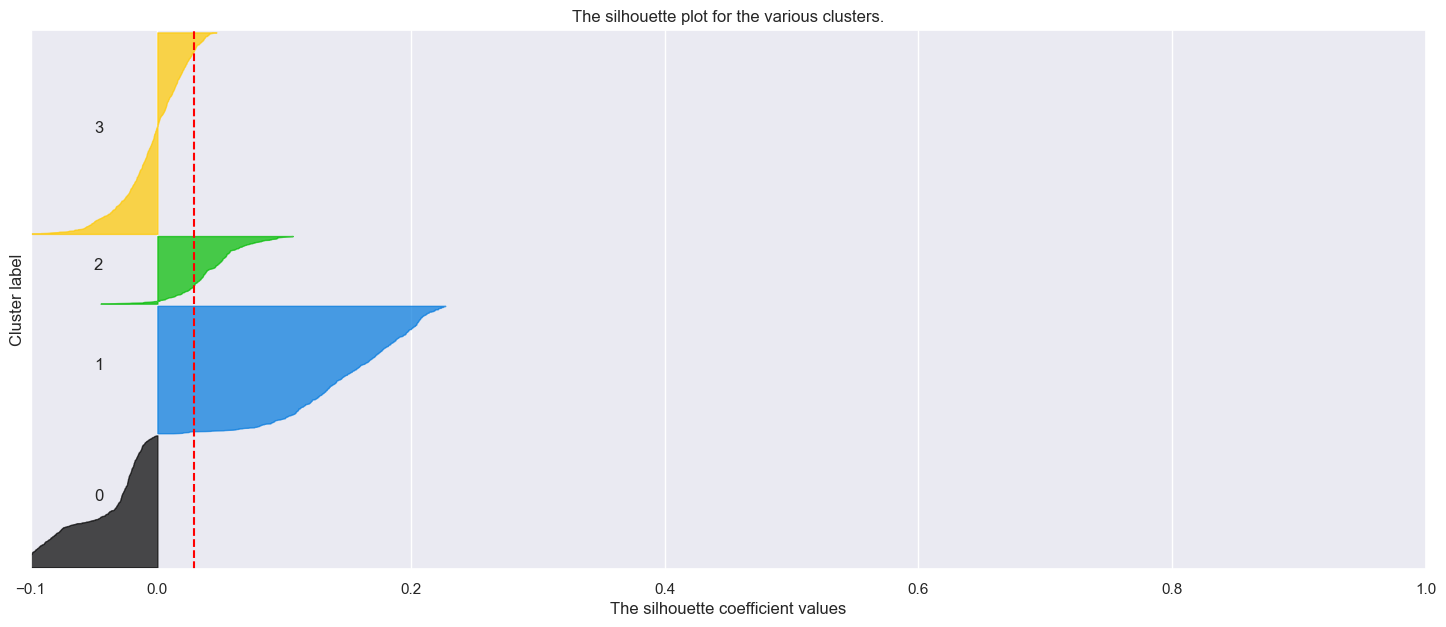

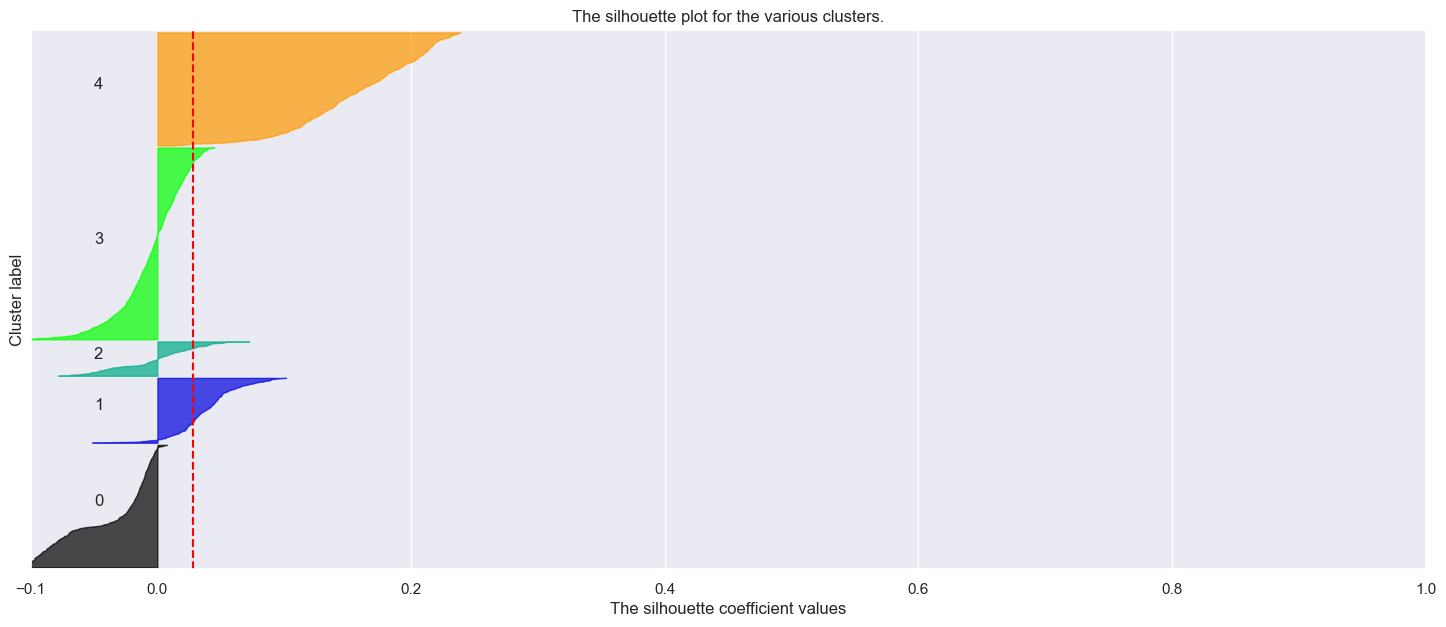

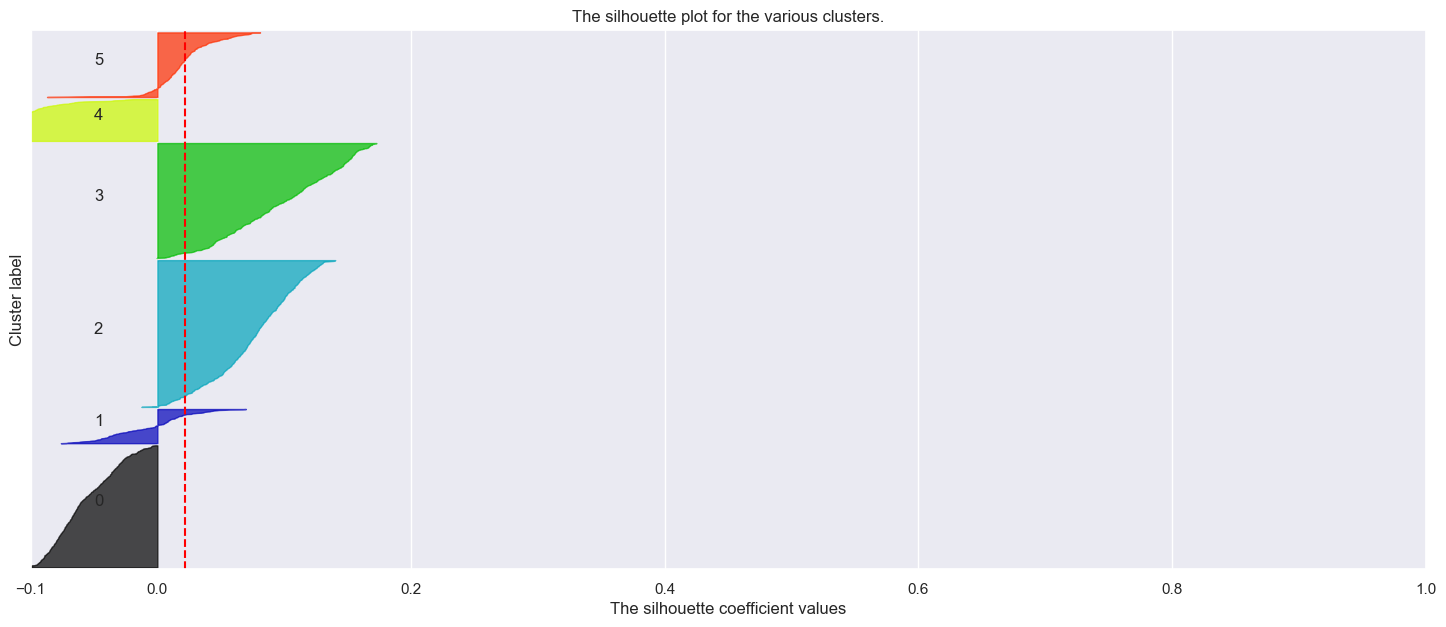

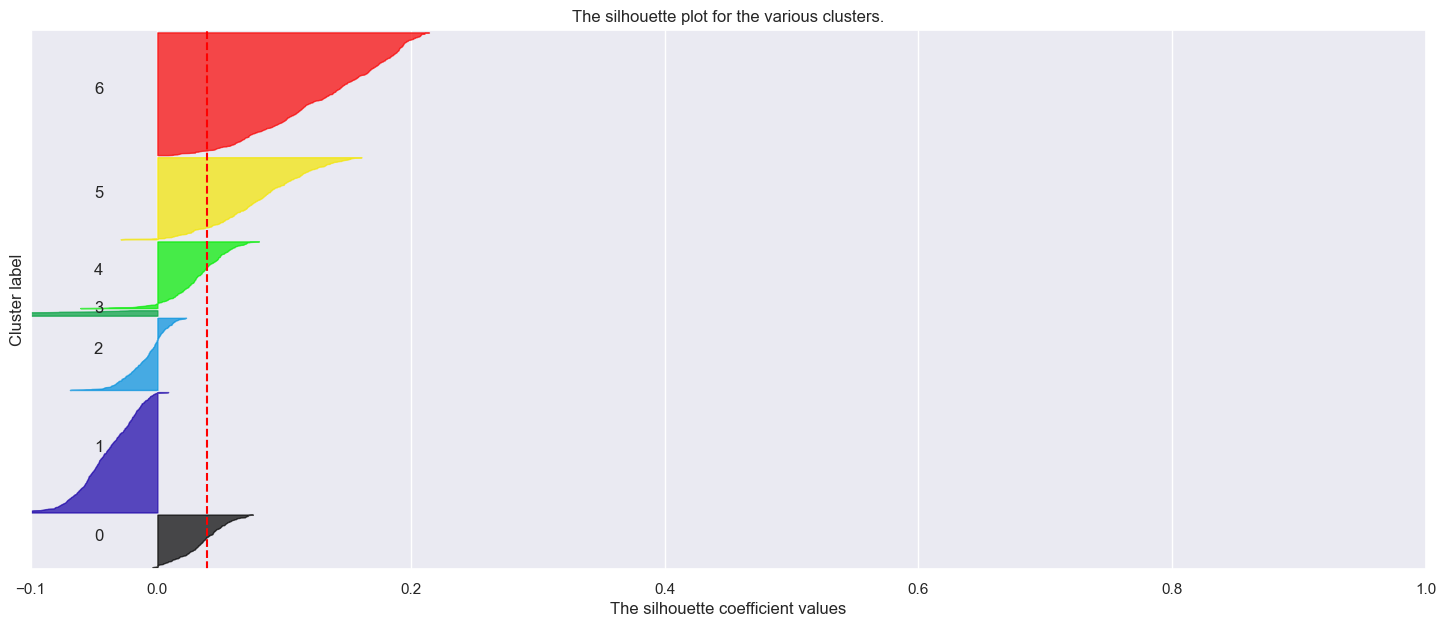

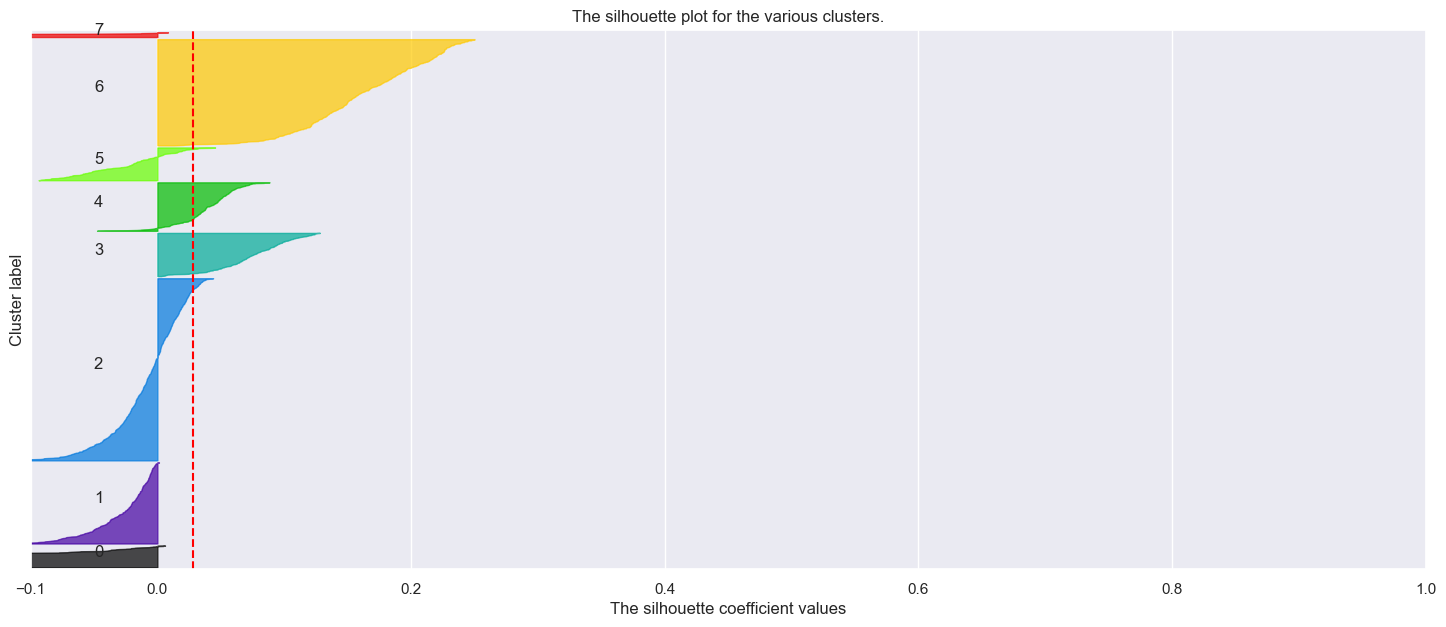

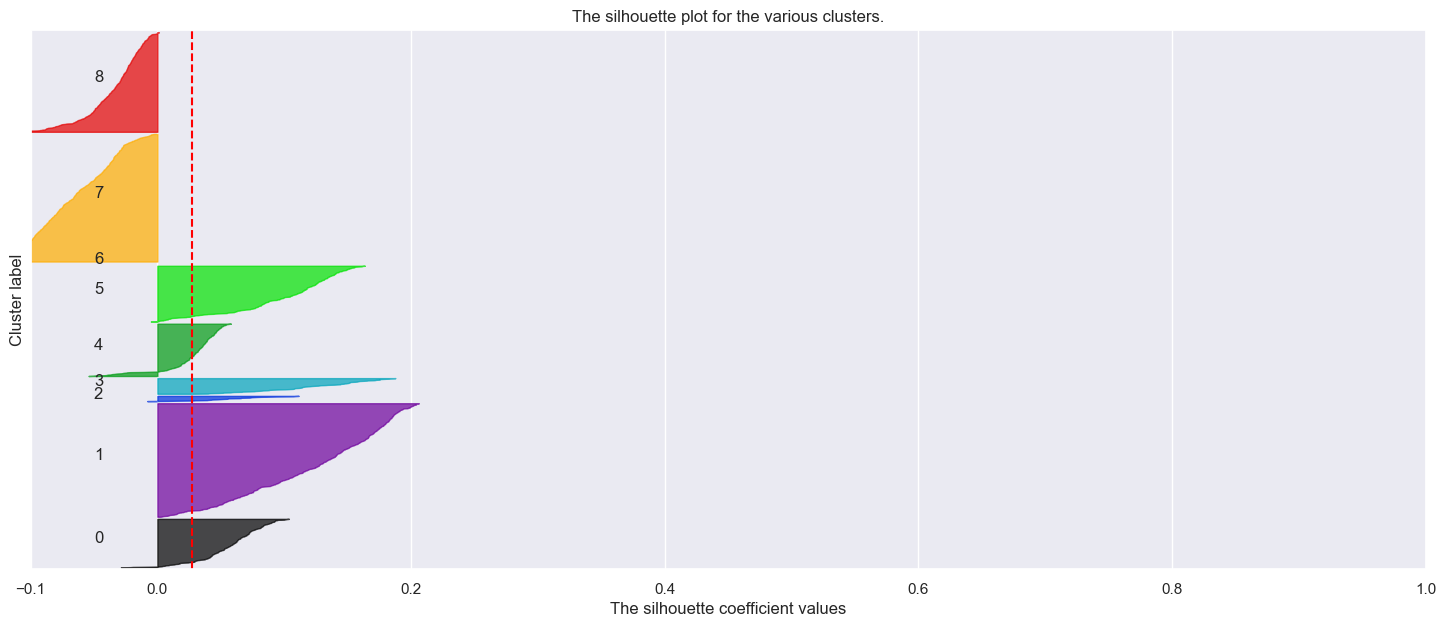

In [493]:
potential_k = list(range(2, 10))
for n_clusters in potential_k:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(data_numeric_standarized) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(data_numeric_standarized)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data_numeric_standarized, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data_numeric_standarized, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [494]:
import umap
reducer = umap.UMAP(n_components=2)
umap_model = reducer.fit(data_numeric_standarized)

In [495]:
training_data_embedding = umap_model.transform(data_numeric_standarized)
centers_embedding = umap_model.transform(centers)

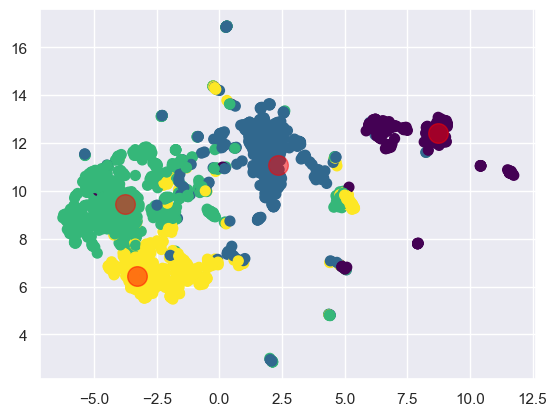